<a href="https://colab.research.google.com/github/JohnFBraman/AI-Crash-Course/blob/master/road_Seg_Elev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data fetched successfully!
        id                                           geometry           name  \
0  5938529  LINESTRING (-117.3061 33.07573, -117.30597 33....           None   
1  5939066  LINESTRING (-117.28992 33.08072, -117.29007 33...           None   
2  5939068  LINESTRING (-117.30135 33.08403, -117.30143 33...           None   
3  5939555  LINESTRING (-117.30358 33.07524, -117.30367 33...           None   
4  5940748  LINESTRING (-117.23459 33.07801, -117.23466 33...  Calle Caracas   

       highway service  
0      service    None  
1      service    None  
2      service    None  
3      service    None  
4  residential    None  
Total number of road segments: 3220
Data saved as 'fetched_ways.geojson'
        id  length_meters
0  5938529      12.626169
1  5939066      73.908607
2  5939068     274.248163
3  5939555     184.504582
4  5940748      22.187438
Total number of ways: 3220
Number of unique ways: 3220
Data loaded successfully! Number of ways: 3220
Number of e

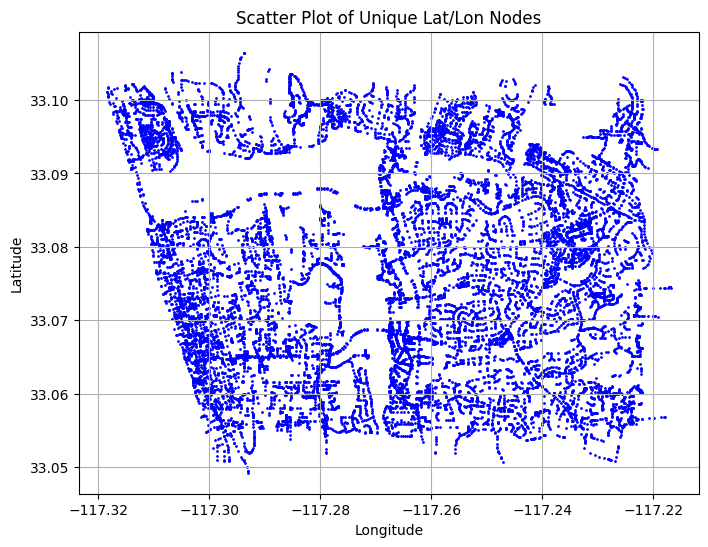

In [1]:
import requests
import json
import geopandas as gpd
from shapely.geometry import LineString

def fetch_data_from_overpass():
    """
    Fetch data from Overpass API within a bounding box
    and return the JSON response.
    """
    # Define the bounding box (lat_min, lon_min, lat_max, lon_max)
    bounding_box = (33.0552, -117.3675, 33.1000, -117.2225)

    # Overpass API URL
    overpass_url = "https://overpass-api.de/api/interpreter"

    # Overpass API query
    query = f"""
    [out:json][timeout:25];
    way["highway"~"^(primary|secondary|tertiary|residential|unclassified|service|living_street)$"]
      ({bounding_box[0]}, {bounding_box[1]}, {bounding_box[2]}, {bounding_box[3]})
      ["highway"!~"^(footway|path|bridleway|golf_cart|golf)$"]
      ["golf"!="cartpath"]
      ["golf_cart"!="designated"]
      ["service" != "parking_aisle"];
    (._; >;);
    out geom;
    """
    # Fetch data from Overpass API
    response = requests.get(overpass_url, params={"data": query})

    # Check if the request was successful
    if response.status_code == 200:
        print("Data fetched successfully!")
        overpass_response = response.json()
    else:
        print(f"Failed to fetch data. HTTP status code: {response.status_code}")
        overpass_response = None

    return overpass_response

def process_and_display_data(overpass_response):
    """
    Convert the Overpass JSON response into a GeoDataFrame and save as GeoJSON.
    Returns the GeoDataFrame (or None if there's no data).
    """
    if not overpass_response:
        print("No data to process.")
        return None

    elements = overpass_response.get('elements', [])
    ways = []
    for element in elements:
        # Ensure it's a 'way' with geometry
        if element['type'] == 'way' and 'geometry' in element:
            coords = [(node['lon'], node['lat']) for node in element['geometry']]
            tags = element.get('tags', {})

            # Create the record, including 'name' tag (if present)
            way_record = {
                "id": element['id'],
                "geometry": LineString(coords),
                "name": tags.get("name"),       # The road name, if any
                "highway": tags.get("highway"),
                "service": tags.get("service")
                # Add more tags if desired
            }
            ways.append(way_record)

    if not ways:
        print("No ways found in the Overpass response.")
        return None

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(ways, geometry='geometry', crs="EPSG:4326")

    # Preview the first few rows
    print(gdf.head())

    # Check the total number of road segments
    print(f"Total number of road segments: {len(gdf)}")

    # Save to a file
    gdf.to_file("fetched_ways.geojson", driver="GeoJSON")
    print("Data saved as 'fetched_ways.geojson'")

    return gdf

def unique_nodes_plot_1():
    """
    we determine the unique nodes of in the ways file.

    """
    import geopandas as gpd
    import pandas as pd
    import requests
    import time

    # Step 1: Load GeoJSON file
    gdf = gpd.read_file("fetched_ways.geojson")
    print(f"Data loaded successfully! Number of ways: {len(gdf)}")

    # Extract all nodes from the geometries (linestrings)
    node_data = []
    for way_id, line in zip(gdf['id'], gdf['geometry']):
        if line.geom_type == 'LineString':
            for coord in line.coords:
                node_data.append({'way_id': way_id, 'lat': coord[1], 'lon': coord[0]})

    # Convert to DataFrame
    nodes_df = pd.DataFrame(node_data)
    print(f"Number of extracted nodes: {len(nodes_df)}")

    # Step 2: Deduplicate lat/lon pairs
    unique_coords = nodes_df[['lat', 'lon']].drop_duplicates().reset_index(drop=True)
    print(f"Number of unique lat/lon pairs: {len(unique_coords)}")

    # Preview the first few rows (optional)
    print("Preview of unique lat/lon pairs:")
    print(unique_coords.head())


    import matplotlib.pyplot as plt

    # Suppose you've already created `unique_coords` from your GeoDataFrame:
    # unique_coords = nodes_df[['lat', 'lon']].drop_duplicates().reset_index(drop=True)

    # 1. Basic scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(unique_coords["lon"], unique_coords["lat"], s=1, color="blue")

    plt.title("Scatter Plot of Unique Lat/Lon Nodes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)

    plt.show()

    return(unique_coords)


# --- Main Execution ---
if __name__ == '__main__':
    # 1. Fetch Overpass data
    overpass_response = fetch_data_from_overpass()

    # 2. Process and display (which also saves to 'fetched_ways.geojson')
    gdf = process_and_display_data(overpass_response)

    # If we got a valid GeoDataFrame, do further processing
    if gdf is not None:
        # Reproject to a metric CRS (UTM Zone 11N for southern CA, EPSG:32611)
        gdf_metric = gdf.to_crs(epsg=32611)

        # Calculate lengths in meters
        gdf_metric['length_meters'] = gdf_metric.geometry.length

        # Preview results
        print(gdf_metric[['id', 'length_meters']].head())

        # Total number of rows in the dataset (number of ways)
        total_ways = gdf_metric.shape[0]
        print(f"Total number of ways: {total_ways}")

        # Alternatively, count unique 'id' values to ensure no duplicates
        unique_ways = gdf_metric['id'].nunique()
        print(f"Number of unique ways: {unique_ways}")

        # Uncomment if/when you want to run the elevation code:
        unique_coords = unique_nodes_plot_1()


